In [84]:
import ibis
from ibis.sql.postgres import existing_udf

con = ibis.postgres.connect(
    host='localhost',
    port=25432,
    user='dengueadmin',
    password='aldengue',
    database='dengue'
)
con.list_tables()

['auth_group',
 'auth_group_permissions',
 'auth_permission',
 'auth_user',
 'auth_user_groups',
 'auth_user_user_permissions',
 'chunked_upload_chunkedupload',
 'dbf_dbf',
 'dbf_dbfchunkedupload',
 'django_admin_log',
 'django_content_type',
 'django_migrations',
 'django_session',
 'geography_columns',
 'geometry_columns',
 'raster_columns',
 'raster_overviews',
 'spatial_ref_sys',
 'teste',
 'uf_total_chik_view',
 'uf_total_view',
 'uf_total_zika_view']

In [22]:
schema_dengue_global = con.schema('Dengue_global')
schema_dengue_global.list_tables()

['CID10', 'Municipio', 'estado', 'parameters', 'regional_saude']

In [23]:
t_estado = schema_dengue_global.table('estado')
t_estado[t_estado.nome, t_estado.uf, t_estado.geocodigo].head().execute()

,nome,uf,geocodigo
0,MINAS GERAIS,mg,31
1,PERNAMBUCO,pe,26
2,ALAGOAS,al,27
3,MARANHÃO,ma,21
4,RONDÔNIA,ro,11


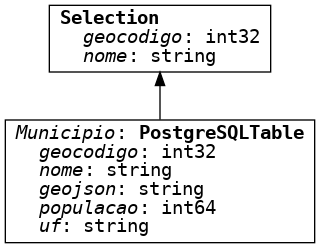

In [24]:
# preare cities dictionary
t_cities = schema_dengue_global.table('Municipio')

uf_filter_ceara = t_cities.uf == 'Ceará'
keys = [t_cities.geocodigo, t_cities.nome]

expr_cities = t_cities[uf_filter_ceara][keys]

df_cities = expr_cities.execute().set_index('geocodigo')
cities = df_cities.to_dict()['nome']

expr_cities

In [12]:
df_cities

,nome
geocodigo,
2305233,Horizonte
2305266,Ibaretama
2305308,Ibiapina
2305332,Ibicuitinga
2305357,Icapuí
...,...
2313807,Uruburetama
2313906,Uruoca
2313955,Varjota


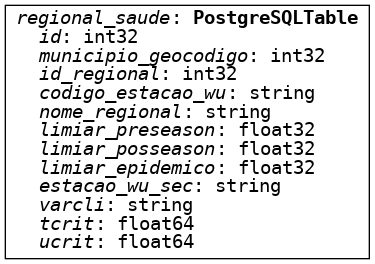

In [25]:
# prepare station_id
t_rsaude = schema_dengue_global.table('regional_saude')
t_rsaude

In [26]:
rsaude_keys = [
    t_rsaude.municipio_geocodigo,
    t_rsaude.codigo_estacao_wu,
    t_rsaude.varcli,
    t_cities.uf,
    t_cities.nome
]

expr_rsaude = t_rsaude.join(
    t_cities, 
    (t_rsaude.municipio_geocodigo == t_cities.geocodigo) 
    & (t_cities.uf == 'Ceará')
)
print(expr_rsaude[rsaude_keys].head().execute())

   municipio_geocodigo codigo_estacao_wu    varcli     uf         nome
0              2305233              SBFZ  umid_max  Ceará    Horizonte
1              2305266              SBTE  umid_max  Ceará    Ibaretama
2              2305308              SBFZ  umid_max  Ceará     Ibiapina
3              2305332              SBTE  umid_max  Ceará  Ibicuitinga
4              2305357              SBFZ  umid_max  Ceará       Icapuí


In [64]:
var_climate = 'umid_max'
year_week = 202002
station_id = 'SBFZ'

general_param = {
    'year_week_start': year_week - 200,
    'year_week_end': year_week,
    'geocodes': ','.join(map(lambda v: repr(str(v)), cities)),
    'geocodes_list': [v for v in cities],
    'var_climate': var_climate,
    'station_id': station_id,
}

disease = 'dengue'

_param = dict(general_param)
_param['disease'] = disease

table_suffix = ''
if disease != 'dengue':
    table_suffix = '_{}'.format(disease)

_param['table_suffix'] = table_suffix

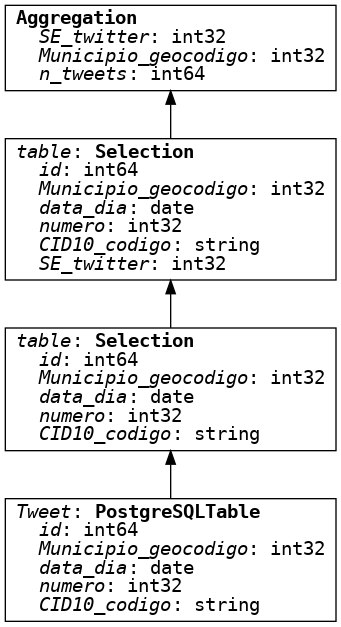

In [105]:
epi_week_fn = existing_udf(
    'epi_week',
    input_types=['date'],
    output_type='int32'
)

t_tweet = schema_city.table('Tweet')
filter_tweet_cities = t_tweet.Municipio_geocodigo.isin(
    general_param['geocodes_list']
)
t_tweet = t_tweet[filter_tweet_cities]
t_tweet = t_tweet.mutate(SE_twitter=epi_week_fn(t_tweet.data_dia))

expr_tweet = t_tweet.groupby([
    t_tweet.SE_twitter,
    t_tweet.Municipio_geocodigo,
    
]).aggregate(
    n_tweets=t_tweet.numero.sum()
)

filter_tweet = (
    t_tweet.SE_twitter.between(
        general_param['year_week_start'], 
        general_param['year_week_end']
    )
)

# ORDER BY "SE_twitter" DESC
expr_tweet = expr_tweet[filter_tweet].sort_by(('SE_twitter', False))
expr_tweet

In [114]:
schema_city = con.schema('Municipio')

epi_week_fn = existing_udf(
    'epi_week',
    input_types=['date'],
    output_type='int32'
)

joined_expr = None
previous_expr = {}
previous_disease = ''

for disease in ['dengue', 'chik', 'zika']:
    t_hist = schema_city.table('Historico_alerta{}'.format(table_suffix))

    case_level = (
        ibis.case()
        .when((t_hist.nivel.cast('string') == '1'), 'verde')
        .when((t_hist.nivel.cast('string') == '2'), 'amarelo')
        .when((t_hist.nivel.cast('string') == '3'), 'laranja')
        .when((t_hist.nivel.cast('string') == '4'), 'vermelho')
        .else_('-')
        .end()
    ).name(f'nivel_{disease}')

    hist_keys = [
        t_hist.SE.name(f'SE_{disease}'),
        t_hist.casos.name(f'casos_{disease}'),
        t_hist.p_rt1.name(f'p_rt1_{disease}'),
        t_hist.casos_est.name(f'casos_est_{disease}'),
        t_hist.p_inc100k.name(f'p_inc100k_{disease}'),
        t_hist.nivel.name(f'level_code_{disease}'),
        case_level,
        t_hist.municipio_geocodigo.name(f'geocode_{disease}')
    ]

    hist_filter = (
        (t_hist['SE'].between(general_param['year_week_start'], general_param['year_week_end']))
        & (t_hist['municipio_geocodigo'].isin(general_param['geocodes_list']))
    )

    hist_expr = t_hist[hist_filter][hist_keys].sort_by(f'SE_{disease}')
    
    if joined_expr is None:
        joined_expr = hist_expr
    else:
        # todo: review join approach
        hist_prev = previous_expr[previous_disease]
        joined_cond = (
            (hist_prev[f'SE_{previous_disease}'] == hist_expr[f'SE_{disease}'])
            & (hist_prev[f'geocode_{previous_disease}'] == hist_expr[f'geocode_{disease}'])
        )
        joined_expr = joined_expr.left_join(
            hist_expr,
            joined_cond
        )
    previous_expr[disease] = hist_expr
    previous_disease = disease

# twitter data
t_tweet = schema_city.table('Tweet')
filter_tweet_cities = t_tweet.Municipio_geocodigo.isin(
    general_param['geocodes_list']
)
t_tweet = t_tweet[filter_tweet_cities]
t_tweet = t_tweet.mutate(SE_twitter=epi_week_fn(t_tweet.data_dia))

expr_tweet = t_tweet.groupby([
    t_tweet.SE_twitter,
    t_tweet.Municipio_geocodigo,

]).aggregate(
    n_tweets=t_tweet.numero.sum()
)

filter_tweet = (
    t_tweet.SE_twitter.between(
        general_param['year_week_start'], 
        general_param['year_week_end']
    )
)

expr_tweet = expr_tweet[filter_tweet].sort_by(('SE_twitter', False))

expr_dengue = previous_expr['dengue']

joined_expr = joined_expr.left_join(
    expr_tweet, 
    (
        (
            expr_tweet.Municipio_geocodigo == expr_dengue.geocode_dengue
        ) & (
            expr_tweet.SE_twitter == expr_dengue.SE_dengue
        )
    )
)

%time joined_expr.materialize().head().execute()

CPU times: user 186 ms, sys: 3.76 ms, total: 190 ms
Wall time: 8.79 s


,SE_dengue,casos_dengue,p_rt1_dengue,casos_est_dengue,p_inc100k_dengue,level_code_dengue,nivel_dengue,geocode_dengue,SE_chik,casos_chik,...,casos_zika,p_rt1_zika,casos_est_zika,p_inc100k_zika,level_code_zika,nivel_zika,geocode_zika,SE_twitter,Municipio_geocodigo,n_tweets
0,201802,0,0.000000,0.0,0.000000,1,verde,2311355,201802,0,...,0,0.000000,0.0,0.000000,1,verde,2311355,NaN,NaN,NaN
1,201802,0,0.000000,0.0,0.000000,1,verde,2302107,201802,0,...,0,0.000000,0.0,0.000000,1,verde,2302107,201802.0,2302107.0,0.0
2,201802,11,0.998492,11.0,60.682999,2,amarelo,2313005,201802,11,...,11,0.998492,11.0,60.682999,2,amarelo,2313005,NaN,NaN,NaN
3,201802,0,0.000000,0.0,0.000000,1,verde,2311801,201802,0,...,0,0.000000,0.0,0.000000,1,verde,2311801,NaN,NaN,NaN
4,201802,0,0.000000,0.0,0.000000,1,verde,2303907,201802,0,...,0,0.000000,0.0,0.000000,1,verde,2303907,201802.0,2303907.0,0.0


In [115]:
"""
climate_join = (
    '''
LEFT JOIN (
  SELECT
     epi_week(data_dia) AS epiweek_climate,
     AVG(%(var_climate)s) AS %(var_climate)s
  FROM "Municipio"."Clima_wu"
  WHERE "Estacao_wu_estacao_id" = '%(station_id)s'
  GROUP BY epiweek_climate
  ORDER BY epiweek_climate
) AS climate_wu
   ON (dengue."SE_dengue"=climate_wu.epiweek_climate)
'''
    % general_param
)

sql += climate_join + tweet_join

sql = ' SELECT {} FROM ({}) AS data'.format(','.join(k), sql)
""";

In [60]:
print(hist_expr.count().execute())

19320


In [63]:
184*52+184*53

19320